#### 1. Import libraries

In [1]:
# For image manipulation, drawing
from PIL import Image,ImageDraw

# For image encoding and encoding
from io import BytesIO
import base64, json

# GCP project ressources browsing
import googleapiclient.discovery

#### 2. Define HERE your projects credentials

In [2]:
# Your project ID
project="master-tp-polytech"

# Your models names (not version name)
model_line_detector="digit_line_detector"
model_digit_reader="digit_reader"

#### 3. Define useful functions

In [3]:
# Deactivate SSL verification and avoid errors (timeout/certificate not verified, etc.)
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

In [4]:
# Define a function that will make a call to the deployed 
# model through a JSON and an HTTP request
def predict_json(project, model, instances, version=None):
    """Send json data to a deployed model for prediction.
    Args:
        project (str): project where the Cloud ML Engine Model is deployed.
        model (str): model name.
        instances ([[float]]): List of input instances, where each input
           instance is a list of floats.
        version: str, version of the model to target.
    Returns:
        Mapping[str: any]: dictionary of prediction results defined by the
            model.
    """
    # Create the ML Engine service object.
    # No need to authenticate since you're at the inner of the project itself
    # In a VM that belongs to the project
    
    # Retrieve the model ressource
    service = googleapiclient.discovery.build('ml', 'v1')
    name = 'projects/{}/models/{}'.format(project, model)
    
    if version is not None:
        name += '/versions/{}'.format(version)
    
    # Predict with the model and the JSON request
    response = service.projects().predict(
        name=name,
        body={'instances': instances}
    ).execute()

    if 'error' in response:
        raise RuntimeError(response['error'])

    return response['predictions']

In [5]:
# Define a function that will translates the relative coordinates 
# returned by the TensorFlow model to absolute coordinates for plotting/cropping
def getCoordinates(boxes, image, numDetection):
    
    #ATTENTION : ON RECOIT [ymin, xmin, ymax, xmax]
    
    height=image.height
    width=image.width
    
    coordinates=[]
    for i in range(int(numDetection)) :
        
        coords = (boxes[i][0]*height,
                  boxes[i][1]*width,
                  boxes[i][2]*height,
                  boxes[i][3]*width)
        
        coordinates.append(coords)
        
    return coordinates

#### 4. Apply the processing to an image

In [7]:
# Define image path
image_path="images/img_001.jpg"

Base image :


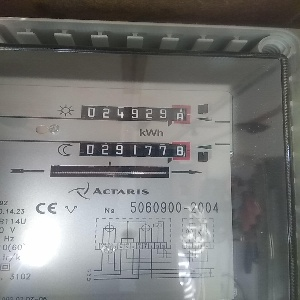


Base image - digits area detected :


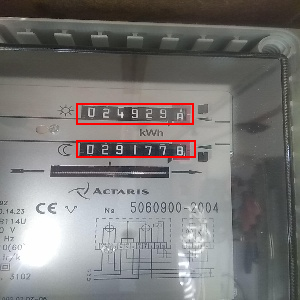


Cropped image 0 - not modified :



Cropped image 0 - digits detected :



Cropped image 1 - not modified :



Cropped image 1 - digits detected :


In [11]:
# Extract name and extension from path
image_name=image_path[:-4]
image_extension=image_path[-4:]

# Open the image file
with open(image_path, 'rb') as f:
    b64_x = f.read()

print("==========================================================")
print("Base image :")
image=Image.open(image_path)
display(image)

# Encode the image in Base64 string for sending it out 
# Base64 string is a more efficient encoding than using a matrix notation
b64_x = base64.b64encode(b64_x).decode('utf-8')
input_instance=[{"inputs": {"b64": b64_x}}]

# Predict the box value for meter line detection (the digit are)
response=predict_json(project, model_line_detector, input_instance)

# Transform coordinates
coordinates=getCoordinates(response[0]["detection_boxes"],image, response[0]["num_detections"])

# For each box predicted, crop the base image and create a sub-image to feed 
# second model (for digits reading). On top, draw the rectangles in the base image
sub_images=[]
for coords in coordinates:
    tmp=image.crop((coords[1],coords[0],coords[3],coords[2]))
    sub_images.append(tmp)
    
    draw = ImageDraw.Draw(image)
    draw.rectangle(((coords[1],coords[0]), (coords[3],coords[2])), outline="red", width=2)

# Plot first image modified
print("")
print("==========================================================")
print("Base image - digits area detected :")
display(image)

# For each sub-image (cropped image), apply the prediction process with the second model
# that aims to read the meter digits. On top, draw digits boxes and write digit text
for i in range(len(sub_images)):
    
    print("")
    print("==========================================================")
    print("Cropped image {} - not modified :".format(i))
    display(sub_images[i])
    
    # Encode sub-image to base64 and compose request json
    buffered = BytesIO()
    sub_images[i].save(buffered, format="JPEG")
    b64_x = base64.b64encode(buffered.getvalue()).decode('utf-8')
    input_instance=[{"inputs": {"b64": b64_x}}]
    
    # Predict the box value for meter digits
    response=predict_json(project, model_digit_reader, input_instance)
    
    # Transform coordinates and retrieve good label
    coordinates=getCoordinates(response[0]["detection_boxes"],sub_images[i], response[0]["num_detections"])
    labels=response[0]["detection_classes"][:int(response[0]["num_detections"])]
    
    # Draw the digit boxes and labels on the sub-image
    draw = ImageDraw.Draw(sub_images[i])
    for idx,coords in enumerate(coordinates):
        #DRAW RECTANGLE AND PLOT SUB IMAGES
        draw.rectangle(((coords[1],coords[0]), (coords[3],coords[2])), outline="red", width=2)
        draw.text((coords[1],coords[0]), str(int(labels[idx])-1), fill=(0, 207, 255))
    
    print("")
    print("Cropped image {} - digits detected :".format(i))
    display(sub_images[i])